# Project 1: Projectile Motion

Double tap this cell to get to edit mode and fill in the information below.

> Full Name:

> Date: 28 September 2023

> Resources Used:

## Tips

  * Python tutorials:
     * PythonMinimum
     * [A short introduction](https://realpython.com/python-first-steps/)
     * [A more complete introduction](https://www.w3schools.com/python/default.asp)
  * Use __esc r__ to disable a cell
  * Use __esc y__ to reactivate it
  * Use __esc m__ to go to markdown mode. **Markdown** is the typesetting language used in jupyter notebooks.
  * In a markdown cell, double tap the mouse or glide pad (on your laptop) to go to edit mode. 
  * Shift + return to execute a cell (including markdown cells).
  * If the equations don't typeset, try double tapping the cell again, and re-execute it.
  

## Learning Objectives
  * Learn how to solve Newton's second law of motion numerically.
  * Learn about the motion of projectiles and how friction affects the motion
  * Learn more about programming in Python
  * Learn how to superimpose plots
 
**Part 1** of this notebook gives an example of how to compute a trajectory and make a plot. You must write your assignment in **Part 2** of the notebook, which starts with a set of questions that you must answer. 

When you write your assignment in **Part 2**, feel free to reuse anything in **Part 1** of the notebook. For example, it should be possible for you to reuse `propagate`, `force`, and `compute_trajectory`. But, of course, feel free to write your own versions of these functions if you wish. 

## Numerical Solution of Newton's Second Law

### Newton's second law
Newton's second law of motion for a particle of mass $m$ is

$$\vec{F} = m \vec{a},$$ 

where, by definition, the acceleration is

$$\vec{a} = \frac{d\vec{v}}{dt}, $$

and $\vec{F}$ is the sum of all forces acting on the particle. (Note: The second law applies to every particle that comprises an extended object.) The second law can be written as two first order **ordinary differential equations** (ODE),

\begin{align}
    \frac{d\vec{r}}{dt} & = \vec{v}, \\
    \frac{d\vec{v}}{dt} & = \frac{1}{m} \vec{F} .
\end{align}

These equations can be solved approximately using the formulae

\begin{align}
    \vec{r}(t + h) & = \vec{r}(t) + \vec{v}(t) \, h  + \frac{1}{2} \frac{\vec{F}(t)}{m}  \, h^2 + {\cal O}(h^3),\\
    \vec{v}(t + h) & = \vec{v}(t) + \frac{\vec{F}(t)}{m}  \, h + {\cal O}(h^2) .
\end{align}

The symbol ${\cal O}(h^3)$ represents all terms proportional to $h^3$ and to higher powers of $h$. Likewise for ${\cal O}(h^2)$. We'll choose $h$ small enough so that these terms can be neglected. 

### Import modules 
Make Python modules (that is, collections of programs) available to this notebook.


In [1]:
import os, sys
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import sympy as sm

sm.init_printing()        # activate "pretty printing" of symbolic expressions
%matplotlib inline

# update fonts
FONTSIZE = 14
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# use latex if available on system, otherwise set usetex=False
mp.rc('text', usetex=True)

# use JavaScript for rendering animations
mp.rc('animation', html='jshtml')

# set a seed to ensure reproducibility 
# on a given machine
seed = 314159
rnd  = np.random.RandomState(seed)

## Simulating a projectile

  1. **Step 1**: We write a function that implements the vector equations.
  \begin{align}
    \vec{r}(t + h) & = \vec{r}(t) + \vec{v}(t) \, h  + \frac{1}{2} \frac{\vec{F}(t)}{m}  \, h^2 + {\cal O}(h^3),\\
    \vec{v}(t + h) & = \vec{v}(t) + \frac{\vec{F}(t)}{m}  \, h + {\cal O}(h^2) .
\end{align}
  1. **Step 2**: We write a function that implements the total force on the ball.
  1. **Step 3**: We write a function that computes the trajectory.
  1. **Step 3**: Plot the trajectory.

# Part 1

### Constants

In [2]:
# simulation constants
M  = 0.25               # mass of ball (kg)
MU = 0.0                # friction constant N/m/s (N: Newton, unit of force)
g  = 9.81               # acceleration due to gravity (m/s^2)
H  = 0.01               # time step (seconds) 
R0 = np.array((0,1,0))  # initial position of ball
V0 = np.array((4,10,0))
class Bag:              # a very simple class (see PythonMinimum)
    pass

bag    = Bag()
bag.h  = H    # time step (seconds)
bag.hh = H**2
bag.g  = np.array((0, -g, 0)) # acceleration due to gravity
bag.mu = MU   # friction constant (N/m/s)
bag.m  = M    # mass of ball (kg)

## Step 1: Propagator
We start by writing a function that takes the current position $\vec{r}(t)$ and velocity $\vec{v}(t)$ of the (center of the) ball, which is treated as a particle, the sum of the forces acting on the ball (often referred to as the **net force**), $\vec{F}(t)$, and returns the updated position and velocity at timestamp $t + h$ of the particle. 

\begin{align}
    \vec{r}(t + h) & = \vec{r}(t) + \vec{v}(t) \, h  + \frac{1}{2} \frac{\vec{F}(t)}{m}  \, h^2 + {\cal O}(h^3),\\
    \vec{v}(t + h) & = \vec{v}(t) + \frac{\vec{F}(t)}{m}  \, h + {\cal O}(h^2) .
\end{align}

In [3]:
def propagate(r, v, F, bag):    
    h, hh, m = bag.h, bag.hh, bag.m
    
    Fm   = F/m
    rnew = r + v*h + Fm*hh/2
    vnew = v + Fm*h
    
    return rnew, vnew   # return new position and  velocity

## Step 2: Force

The function below returns the total force on the particle. We consider two forces, the force of gravity,

\begin{align}
    \vec{F}_g(t) & = m \vec{g} .
\end{align}

and a simple friction force,

\begin{align}
    \vec{F}_{\mu}(t) & = - \mu  \vec{v} ,
\end{align}

where $\mu$ is a constant.

In [4]:
def force(r, v, bag):
    m = bag.m
    g = bag.g
    mu= bag.mu
    F = m * g - mu * v
    return F

## Step 3: Compute Trajectory
We'll stop the calculations when the projectile reaches the ground.

In [5]:
def compute_trajectory(r0, v0, bag, max_steps=100000):
    '''
    
    r0     initial position
    v0     initial velocity
    '''
    
    # set initial state (r and v are lists of vectors)
    r  = [r0]
    v  = [v0]

    # loop over time steps and stop when the ball hits the ground.
    # notice the indentation with respect to the for i range(max_steps) command.
    # this is how Python knows that the instructions that follow are within 
    # the loop (or if statement etc.)
    for i in range(max_steps):
        
        # "I'm alive" printout
        #if i % 10 == 0:
        #    print(f'\r{i:10d}', end='')
            
        # compute total force on ball
        F = force(r[i], v[i], bag)

        # compute next state of ball (next position and velocity at time t + h)
        rnext, vnext = propagate(r[i], v[i], F, bag)

        # check if we've reached the ground
        x, y, z = rnext # rnext is a vector in 3D space, so it has 3 components
        if y <= 0:
            break # break out of the loop

        # cache (that is save) the next state in the lists r and v
        r.append(rnext)
        v.append(vnext)
        
    #print('\ndone!')
    
    return r, v # return the two lists

In [6]:
r, v = compute_trajectory(R0, V0, bag)

## Step 4: Plot Results

In [7]:
def plot_trajectory(r, v, 
                    xmin=0, xmax=20, 
                    ymin=0, ymax=20, 
                    fgsize=(5, 4), 
                    ftsize=14,
                    color='blue', 
                    filename='projectile.png'):
    '''
 
    Example

    >>> plot_function(r, v) 
    '''

    # extract (x, y) coordinates so we can plot them.
    # the following two instructions are equivalent to
    # the following code:
    # x = []
    # y = []
    # for t in r:
    #     xx, yy, _ = t # t is a vector, which is an element of the list r
    #     x.append(xx)
    #     y.append(yy)
    a = [[t[0], t[1]] for t in r]   # this construct is called list comprehension
    x, y = zip(*a)  # unzip the array a = [[x1, y1], [x2, y2],...] !
    
    # create an empty figure of the specified size and a (single) subplot
    # to be placed within the figure.
    fig, ax = plt.subplots(figsize=fgsize)

    # define domain of graph
    ax.set_xlim(xmin, xmax)
    
    # define range of graph
    ax.set_ylim(ymin, ymax)
        
    # annotate axes
    ax.set_xlabel('$x$ (m)', fontsize=ftsize)
    ax.set_ylabel('$y$ (m)', fontsize=ftsize)

    # plot the trajectory
    ax.plot(x, y, color=color)
    
    # add a grid to the plot
    ax.grid()

    # produce a layout such that the saved plot fits
    # fully within the figure.
    fig.tight_layout()
    
    # save the image to the specified file
    plt.savefig(filename)

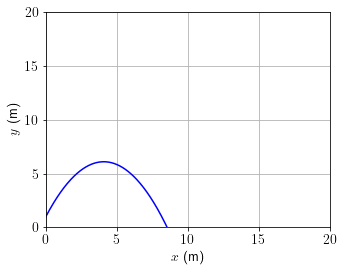

In [8]:
plot_trajectory(r, v)

# Part 2

**Please take note of the following**

  * Before you start, please read the **syllabus** to learn about the **grading rubric**.

  * Each question should be answered in a separate cell. 

Set the friction constant, `bag.mu = 0.0` N/m/s.
  1. Compute the unit vector associated with the vector `V0` given under **Constants**. Call this unit vector `V0unit`.
  1. By scaling `V0unit`, compute your initial velocity `V0`, e.g.,
  ```python
      V0 = scale * V0unit
  ```
  3. Start with `scale = 8.0` m/s, compute and plot the trajectory. Keep increasing the scale until the ball lands at 15m from its starting point. What did you find for the initial speed of the ball (in m/s)?
  1. For how long is the ball in the air? (*Hint*: the time steps are of equal duration.)
  1. Write a version of `plot_trajectory`, call it `plotTrajectory`, which superimposes the exact solution, which is valid when there is no friction, on the plot that shows your approximate numerical solution. Use a different color for the exact solution, find out how to change the line type to dashed rather than continuous, and use a dashed line for the exact solution.
  
The exact solution when there is no friction is

 \begin{align}
  \vec{r}(t) & = \vec{r}_0 + \vec{v}_0 t + \frac{1}{2} \vec{g} t^2, \\
  \vec{v}(t) & = \vec{r}_0 + \vec{g} t,
  \end{align}
  
**Optional** 
  1. Plot the projectile range (i.e., the horizontal distance between the start and end of the trajectory versus the friction constant $\mu$ (`bag.mu`). Choose 20 equally spaced values of `bag.mu` between 0 and 0.80. (*Hint*: `np.linspace`). 
  1. Comment on what you find. For example, if we used larger and larger values of `bag.mu` what would you expect as `bag.mu` becomes very large?

## Solutions

### 1. Compute Unit Vector

In [9]:
V0

array([ 4, 10,  0])

The magnitude of a vector $\vec{A}$ is $A = \sqrt{\vec{A} \cdot \vec{A}}$.

In [10]:
V0mag = np.sqrt(V0.dot(V0))
V0mag

In [11]:
V0mag = np.sqrt(np.dot(V0, V0))
V0mag

In [12]:
V0unit = V0 / V0mag
V0unit

array([0.37139068, 0.92847669, 0.        ])

### 3. Find initial speed to yield a range (horizontal distance traveled) of 15 meters

**NB**: Your grade on this project will, in part, be informed by how well you can explain what's going on in the function `find_initial_speed` and explaining how the function `find_initial_speed2` differs from the first.

You can refer to the commented numbers in your explanation.

In [24]:
# cache the initial position of the ball
bag.R0 = R0
bag.V0unit = V0unit

def find_initial_speed(bag, target_range, min_speed, max_speed, 
                       tolerance=1.e-3, max_iter=50):
    
    r0 = bag.R0         # r0 is an alias for bag.R0
    v0unit = bag.V0unit # v0unit is an alias for bag.V0unit
    
    m = -1
    for i in range(max_iter):
        
        speed = (max_speed+min_speed)/2           # 1
        v0    = speed * v0unit                    # 2
        
        r, v  = compute_trajectory(r0, v0, bag)   # 3
        x, y, z = r[-1]                           # 4
        
        if abs(x - target_range) < tolerance:     # 5
            m = i + 1
            break                                 # 6
            
        elif x < target_range:                    # 7
            min_speed = speed
            
        elif x > target_range:                    # 8
            max_speed = speed
            
    return speed, m


def find_initial_speed2(bag, target_range, min_speed, max_speed, max_iter):
    
    r0 = bag.R0         # r0 is an alias for bag.R0
    v0unit = bag.V0unit # v0unit is an alias for bag.V0unit
    
    for i in range(max_iter):
        
        speed = (max_speed+min_speed)/2           # 1
        v0    = speed * v0unit                    # 2
        
        r, v  = compute_trajectory(r0, v0, bag)   # 3
        x, y, z = r[-1]                           # 4
            
        if   x < target_range:                    # 5
            min_speed = speed
            
        elif x > target_range:                    # 6
            max_speed = speed
            
    return speed

#### Using `find_initial_speed`

In [31]:
target    =  15 # m
min_speed =   8 # m/s
max_speed = 100 # m/s

speed, m = find_initial_speed(bag, target, min_speed, max_speed)

print(f'initial speed of {speed:8.3f} m/s found in {m:d} iterations')

initial speed of   14.424 m/s found in 11 iterations


#### Using `find_initial_speed2`

In [36]:
max_iter = 16

speed = find_initial_speed2(bag, target, min_speed, max_speed, max_iter)

print(f'initial speed of {speed:8.3f} m/s found in {max_iter:d} iterations')

initial speed of   14.425 m/s found in 16 iterations


### Check solution

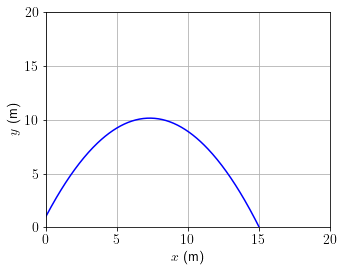

In [34]:
V0 = speed * V0unit
r, v  = compute_trajectory(R0, V0, bag)
plot_trajectory(r, v)

### 4. How long in the air?

### 5.  Superimpose exact solution on your approximate solution

Exact solution.
 \begin{align}
  \vec{r}(t) & = \vec{r}_0 + \vec{v}_0 t + \frac{1}{2} \vec{g} t^2, \\
  \vec{v}(t) & = \vec{r}_0 + \vec{g} t,
  \end{align}
  